<a href="https://colab.research.google.com/github/n4spr/us-x-elections/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#1. Set up.


   ## 1.1. Installing required modules.


In [1]:
#!pip install PyStemmer
#!python -m spacy download en_core_web_sm
#!pip install country_converter
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


## 1.2. Import modules.




In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import re
import json
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#import random
#from matplotlib.colors import LinearSegmentedColormap
#from matplotlib.patches import FancyArrowPatch
#from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
#import spacy
#import Stemmer
plt.style.use('ggplot')


##1.3. Mount google drive.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---


#2. Preprocessing the data and dataframe creation.



> Dataset taken from: https://github.com/sinking8/usc-x-24-us-election?tab=readme-ov-file


> Ref to the arxiv explanation paper: https://arxiv.org/abs/2411.00376



```
This dataset is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International Public License (CC BY-NC-SA 4.0).
```



In [4]:
def preprocess_user(user_data_raw):
    try:
        user_data_cleaned = user_data_raw.replace("'", '"')
        user_data_cleaned = user_data_cleaned.replace("None", "null")
        user_data_cleaned = user_data_cleaned.replace("False", "false")
        user_data_cleaned = user_data_cleaned.replace("True", "true")
        user_data_cleaned = re.sub(r"(datetime\.datetime\([^\)]+\))", r'"\1"', user_data_cleaned)

        # Parse as JSON
        return json.loads(user_data_cleaned)
    except Exception as e:
        # print(f"Error processing user data: {e}")
        return {}

In [5]:
def extract_user_attributes(row):
    user_data = preprocess_user(row)
    return {
        "created": user_data.get("created"),
        "friendsCount": user_data.get("friendsCount"),
        "followersCount": user_data.get("followersCount"),
        "statusesCount": user_data.get("statusesCount"),
        "location": user_data.get("location"),
        "id": user_data.get("id_str"),
        "desc": user_data.get("rawDescription")
    }

## 2.1. Reading data from files and processing.



In [6]:
data_all = pd.DataFrame()
#maxChunks = 20
#for i in range(1, maxChunks+1):
#sampled_chunks = random.sample(range(1, 21), 10)

sampled_chunks = [4, 9, 10, 11, 14, 15, 16, 17, 19, 20]
for i in sampled_chunks:
    try:
        data = pd.read_csv(f"drive/MyDrive/elections/may_july_chunk_{i}.csv", low_memory = False)
        data.dropna(subset=['url', 'text', 'likeCount','in_reply_to_screen_name','user'],inplace=True)
        #data = data.drop(['retweetedTweet', 'location, 'quotedTweet','in_reply_to_status_id_str','in_reply_to_user_id_str','retweetedTweetID','retweetedUserID', 'cash_app_handle', 'date', '_type'], axis=1)
        data.reset_index(drop=True, inplace=True)
        data = data[['url','likeCount','in_reply_to_screen_name','user','text']]
        user_attributes = data["user"].apply(extract_user_attributes)
        user_attributes_df = pd.DataFrame(user_attributes.tolist())
        data.reset_index(drop=True, inplace=True)
        data = pd.concat([data,user_attributes_df],axis=1)
        data["username"] = data["url"].str.extract(r"(?:twitter\.com|x\.com)/([^/]+)/status")
        data = data.drop(['user', 'url'], axis=1)
        data.rename(columns={'in_reply_to_screen_name':'reply_to_user'}, inplace=True)
        data_all = pd.concat([data_all, data], axis = 0)
    except Exception as e:
        print(f"Error while reading the file {i}: {e}")

data_all.head()

likeCount    reply_to_user  \
0        1.0        DougWahl1   
1        0.0        Telegraph   
2        0.0  DynastyDolemite   
3        1.0     BarExamTutor   
4        0.0         SebGorka   

                                                text  \
0  @DougWahl1 I tought everybody new . Hunter and...   
1  @Telegraph We’d like to counter his offer, Con...   
2  @DynastyDolemite @ChuckCjmmn I see radio host,...   
3  @BarExamTutor I came to this realization over ...   
4  @SebGorka @JuliaHB1 @TalkTV Hunter Biden gives...   

                                             created  friendsCount  \
0  datetime.datetime(2019, 1, 3, 2, 31, 33, tzinf...        1759.0   
1  datetime.datetime(2013, 3, 1, 7, 31, 46, tzinf...         274.0   
2  datetime.datetime(2019, 11, 13, 18, 23, 1, tzi...        3428.0   
3                                               None           NaN   
4  datetime.datetime(2022, 11, 22, 12, 9, 37, tzi...         493.0   

   followersCount  statusesCount                  location  \
0          1157.0        47287.0          Montréal, Québec   
1           167.0        12089.0  Scotland, United Kingdom   
2          2868.0         9643.0         Mara Lago Shitter   
3             NaN            NaN                      None   
4           355.0        37386.0     Nottingham, Maryland    

                    id                                               desc  \
0  1080652857429450752                    I’m from Canada. I’m vaccinated   
1           1229250014               loves Volvos and talking to the dead   
2  1194682034079162370  Husband. Girl Dad, Son. Brother. Pro-choice. I...   
3                 None                                               None   
4  1595026565754150912  I ran 10,000 meters as a 20 year old March 21,...   

         username  
0  dussault_helen  
1        liam9904  
2  MagicJordan702  
3         BMB_Esq  
4      m7donofrio

# 3. Dataset exploration.

In [7]:
len(data_all)

357904

<!-- feefe -->


## 3.1 How many tweets from each users are in the dataset?

### 3.1.1. Value counts dataframe of tweets by username.

In [8]:
temp = pd.DataFrame(data_all['username'].value_counts())
print(temp.describe())
temp[0:21]

               count
count  175279.000000
mean        2.041910
std         4.777187
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       309.000000


count
username              
BenStanton77       309
conservativebox    287
petermanbill196    267
JoeBiden268198     247
superdegeen        244
IcanAmer_MAGA      235
FJB311             228
DabbKen            225
MAGAWoodworker     223
EMGENT_007         221
amor0730           220
Annabel99631466    206
NullifyMAGALies    205
vegotsecrets       201
TIMRay29015353     197
nerdy4history      197
JKash000           189
AmmConservative    184
VoteHarrisOut      183
slayerofmoskali    182
DenisefromCali     182

### 3.1.2. Plotting the distribution.

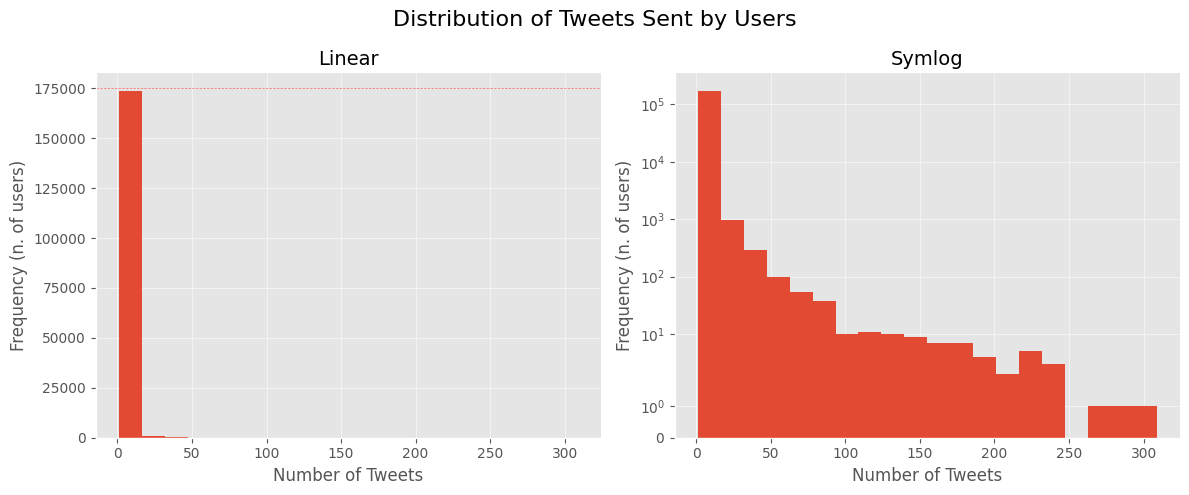

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Distribution of Tweets Sent by Users', fontsize=16)
tot = temp.count().iloc[0]
# Plot 1
axes[0].hist(temp['count'], bins=20)
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_xlabel("Number of Tweets", fontsize=12)
axes[0].set_ylabel("Frequency (n. of users)", fontsize=12)
axes[0].set_title('Linear', fontsize=14)
axes[0].grid(True, alpha=0.5)

# Plot 2
axes[1].hist(temp['count'], bins=20)
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].set_xlabel("Number of Tweets", fontsize=12)
axes[1].set_ylabel("Frequency (n. of users)", fontsize=12)
axes[1].set_yscale('symlog', linthresh=2)
axes[1].set_title('Symlog', fontsize=14)
axes[1].grid(True, alpha=0.5)

axes[0].axhline(y=tot, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
#axes[1].axhline(y=tot, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

##3.2. For each user how many tweets are a reply to them?




### 3.2.1. Creating replies value counts dataframe.

In [10]:
temp2= pd.DataFrame(data_all['reply_to_user'].value_counts())
print(temp2.describe())
temp2[0:21]

              count
count  76247.000000
mean       4.694008
std       49.699666
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max     5902.000000


count
reply_to_user         
GOP               5902
JoeBiden          4967
harryjsisson      4096
KamalaHQ          3547
harris_wins       2420
GuntherEagleman   2327
POTUS             1970
ProudElephantUS   1902
simonateba        1715
MTGrepp           1646
mmpadellan        1600
GrandpaDennisP    1562
catturd2          1544
Travis_4_Trump    1536
robreiner         1494
CollinRugg        1441
JoJoFromJerz      1400
DonaldTNews       1313
kangaroos991      1240
acnewsitics       1212
Acyn              1204

### 3.2.2. Plotting the frequencies distribution.

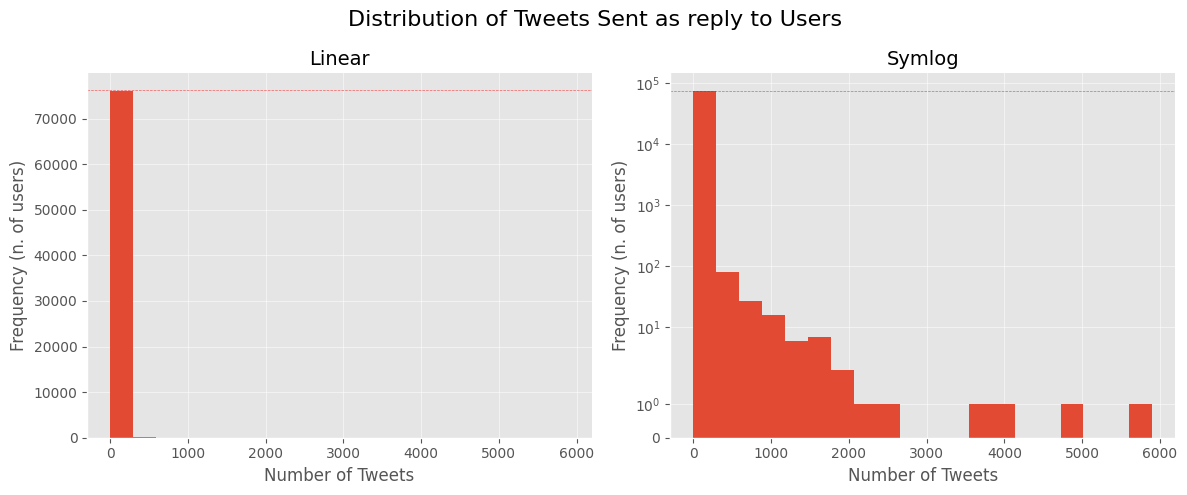

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Distribution of Tweets Sent as reply to Users', fontsize=16)
tot = temp2.count().iloc[0]
# Plot 1
axes[0].hist(temp2['count'], bins=20)
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_xlabel("Number of Tweets", fontsize=12)
axes[0].set_ylabel("Frequency (n. of users)", fontsize=12)
axes[0].set_title('Linear', fontsize=14)
axes[0].grid(True, alpha=0.5)

# Plot 2
axes[1].hist(temp2['count'], bins=20)
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].set_xlabel("Number of Tweets", fontsize=12)
axes[1].set_ylabel("Frequency (n. of users)", fontsize=12)
axes[1].set_yscale('symlog', linthresh=2)
axes[1].set_title('Symlog', fontsize=14)
axes[1].grid(True, alpha=0.5)


axes[0].axhline(y=tot, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].axhline(y=tot, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


## 3.3. How is the tweets length attribute distributed?


### 3.3.1. Tweet-lengths series creation.

In [12]:
text_lengths = pd.Series([len(x) for x in data_all['text']])
text_lengths.describe()

count    357904.000000
mean        142.782252
std          95.764740
min           1.000000
25%          65.000000
50%         119.000000
75%         213.000000
max         985.000000
dtype: float64

###3.3.2. Plotting the distribution.

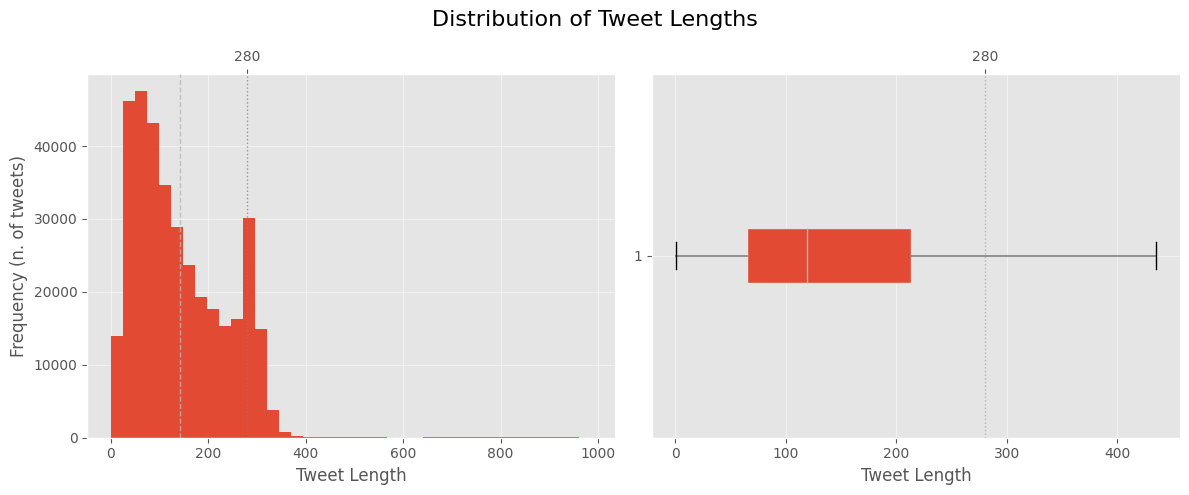

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Distribution of Tweet Lengths', fontsize=16)
# Plot 1
axes[0].hist(text_lengths, bins=40)
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_xlabel("Tweet Length", fontsize=12)
axes[0].set_ylabel("Frequency (n. of tweets)", fontsize=12)
axes[0].axvline(x=text_lengths.mean() , color='#b7b7b7', linestyle='--', linewidth=1, alpha=0.8) #median line
axes[0].axvline(x=280, color='grey', linestyle='dotted', linewidth=1, alpha=0.8)
axes[0].secondary_xaxis('top').set_xticks([280])
axes[0].grid(True, alpha=0.5)
# Plot 2
bp = axes[1].boxplot(text_lengths, vert=False, patch_artist=True, showfliers=False,
                boxprops=dict(facecolor='#E24A33', color='#E5E5E5'),
                medianprops=dict(color='#b7b7b7'))
for whisker in bp['whiskers']:
    whisker.set(color='#808080', linewidth=1.2)
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].set_xlabel("Tweet Length", fontsize=12)
axes[1].axvline(x=280, color='grey', linestyle='dotted', linewidth=1, alpha=0.5)
axes[1].secondary_xaxis('top').set_xticks([280])
axes[1].grid(True, alpha=0.5)

#line = premium user length
plt.tight_layout()
plt.show()

##3.4 Analyzing the location attribute:
is the data a good sample (a representative sample) of the state of origin? \
That is, if 1 out of 100 Americans comes from state X, is the proportion of users from that state X in the tweet dataset also (near) 1/100 (for all states)?


###3.4.1. Reading the state codes and populations data.



> State codes:
https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=53971


> Population data: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP



In [14]:
states = pd.read_csv("drive/MyDrive/elections/usa_codes_pop.csv", sep = ';', thousands=',')
states.reset_index(inplace=True)
states = states.set_index('code')
states.head()

index       state  population
code                               
AL        0     Alabama     5108468
AK        1      Alaska      733406
AZ        2     Arizona     7431344
AR        3    Arkansas     3067732
CA        4  California    38965193

###3.4.2. Dataset creation for location frequency of users

In [15]:
unique_users_df = data_all.drop_duplicates(subset=['username'], keep='first')
temp = unique_users_df.loc[:,'location']
print("Total number of users: " + str(len(temp)))
locations = temp[(temp != '') & (temp.str.lower() != 'earth')]
locations = locations.dropna()
print("Users with valid location:" + str(locations.notna().sum())) # how many twitter users have location data (about 1/2 of total)
loc_freq = pd.DataFrame(locations.value_counts())
loc_freq

Total number of users: 175279
Users with valid location:78987


count
location                    
United States           3326
USA                     1620
Florida, USA            1117
Texas, USA               866
California, USA          846
...                      ...
Baywood, NY                1
Baseball legend            1
Rochdale,                  1
Alta Marca Trevigiana      1
Gwalior                    1

[31778 rows x 1 columns]

### 3.4.3. Function to process the noisy location attribute.
It is noisy because everyone can set theirs profile location with any string: even jokes. For instance as you can see many users have Earths or emojis as
`location`. \
If there is a name of a state inside the ```location```
 attribute the function will substitute it with the official **state** code, othwerwise it will be dropped for this analysis.

In [16]:
def get_state_code(place : str) -> str :
    for st_id in states.index:
        if st_id == 'VA': #to keep West Virginia values from being merged into Virginia
            continue
        if states.loc[st_id,'state'].lower() in place.lower():
            return st_id

    if 'virginia' in place.lower():
        return 'VA'
    return ''
print(get_state_code("Virginia, USA"))
print(get_state_code("West Virginia, USA"))

VA
WV


###3.4.4. Applying the processing function and merging the tweet users `location` proportion with state data.

In [17]:
loc_freq['state_code'] = loc_freq.index.map(get_state_code)
loc_freq = loc_freq[loc_freq['state_code'] != '']

loc_freq_group = loc_freq.groupby('state_code')['count'].sum().reset_index()

loc_freq_group = loc_freq_group.set_index('state_code')
loc_freq_group.index = loc_freq_group.index.astype(str)
loc_freq_group = pd.merge(loc_freq_group, states, left_index=True, right_on='code', how='inner')
# loc_freq_group['log_count'] = np.log1p(loc_freq_group['count'])
loc_freq_group['log_count_prop'] = np.log1p(loc_freq_group['count']) / np.log1p(loc_freq_group['count']).sum() # logarithmic proportion: log(x) / sum_i(log(i))
sample_size = loc_freq_group['count'].sum()
print("Num of users in the sample: " + str(sample_size))
loc_freq_group.head()

Num of users in the sample: 19267


count  index       state  population  log_count_prop
code                                                      
AK       72      1      Alaska      733406        0.015587
AL      193      0     Alabama     5108468        0.019138
AR      156      3    Arkansas     3067732        0.018370
AZ      595      2     Arizona     7431344        0.023216
CA     1693      4  California    38965193        0.027011

###3.4.5. Plotting the proportion of users in each state with am interactive Choropleth map.

Taking the logarithms of the user counts because I wanted the color to be more sensitive in changes at lower values. But it can be more easily done with a more appopriate color-scale or with a tranformation of it (also a much less
computationally expensive option)

In [18]:
map = px.choropleth(
    loc_freq_group.reset_index(),
    locations = 'code',
    locationmode = 'USA-states',
    scope = 'usa',
    color = 'log_count_prop',
    hover_name = 'state',
    hover_data={'log_count_prop': False, 'count': ':,d'},
    color_continuous_scale = 'peach', #'ylorbr','peach', 'oranges','brwnyl'
    title='Twitter users by State',
)
tick_values = [100, 1000, 5000]

formatted_ticks = [f"{val:,.0f}" for val in tick_values]

log_tick_values = np.log1p(tick_values)
#max_count = loc_freq_group['count'].max()
map.update_coloraxes(
    colorbar_title='User Count',
    #colorbar_tickvals=np.log1p(tick_values),
    colorbar_tickvals = np.log1p(tick_values) / np.log1p(loc_freq_group['count']).sum(),
    colorbar_ticktext=formatted_ticks,
)

map.update_layout(
    coloraxis_colorbar=dict(
        x = 0.5,
        y = -0.2,
        orientation="h",
        title="Count",
    )
)

map.show()


###3.4.6. Plotting the proportion of the REAL population in each state with an interactive Choropleth map.







In [19]:
states['log_pop_prop'] = np.log1p(states['population']) / np.log1p(loc_freq_group['population']).sum()

#min_pop = states['population'].min()
#max_pop = states['population'].max()
lt = 1000000
tick_values = [lt,3*lt,10*lt, 30*lt]
formatted_ticks = [f"{val:,.0f}" for val in tick_values]

log_tick_values = np.log1p(tick_values)

map = px.choropleth(
    states.reset_index(),
    locations='code',
    locationmode='USA-states',
    scope='usa',
    color='log_pop_prop',
    hover_name='state',
    hover_data={'log_pop_prop': False, 'population': ':,d'},
    color_continuous_scale='peach',
    title='Population by State',
)

map.update_coloraxes(
    colorbar_title='Population',
    colorbar_tickvals = np.log1p(tick_values) / np.log1p(loc_freq_group['population']).sum(),
    #colorbar_tickvals=log_tick_values,
    colorbar_ticktext=formatted_ticks,
)

map.update_layout(
    coloraxis_colorbar=dict(
        x = 0.5,
        y = -0.2,
        orientation="h",
        title="Population",
    )
)

map.show()


###3.4.7. Plotting the increase/decrease between the percentage of tweeters by state and the percentage represented by the state in the total US population.
For example Florida is 6.7% of total US population but has 12.3% of twitter users in the dataset. 5.6 more but relative to 6.7% it's an 81% increase.
Washington

In [20]:
#percentages with respect to the total distribution of tweets
loc_freq_group['percentage_users'] = 100 * loc_freq_group['count'] / loc_freq_group['count'].sum()
#percentages with respect to the total distribution of population
loc_freq_group['percentage_population'] = 100 * loc_freq_group['population'] / loc_freq_group['population'].sum()

# formula for how much increased the % in tweets with respect to population %:
# x is such that : population_percent * (1 +x/100) = tweet_percent
# so --> x = ( tweet percent/pop_percent - 1) * 100
loc_freq_group['%twit_user_vs_%population'] = 100 * (loc_freq_group['percentage_users'] / loc_freq_group['percentage_population'] - 1)
color_scale = px.colors.diverging.RdBu[::-1]

# Create the choropleth map
map = px.choropleth(
    loc_freq_group.reset_index(),
    locations='code',
    locationmode='USA-states',
    scope='usa',
    color='%twit_user_vs_%population',  # Use the ratio of percentages
    hover_name='state',
    hover_data={
        '%twit_user_vs_%population': ':.2f',
        'percentage_users': ':.4f',
        'percentage_population': ':.4f',
        'population': False,
        'count': False,
    },
    color_continuous_scale=color_scale,
    title='Ratio Between TwitterUsers% and Population% by State',
)

map.update_coloraxes(
    colorbar_title='Difference (% Ratio)',
    colorbar_tickformat='.2f',
    cmid=0
)

map.update_layout(
    coloraxis_colorbar=dict(
        x=0.5,
        y=-0.2,
        orientation="h",
        title="Difference (% Ratio)",
    )
)

map.show()



###3.4.8. Testing statistically the representativity of the sample: Goodness of Fit χ²-*test*.



#### GOF Hypothesis Test

#### Explanation of the Symbols:
- **k** : Number of categories (states) in the population.
- **n** : Total number of observations in the sample.
- **oᵢ** : Observed tweeters count for the i-th state.
-p<sub>i</sub> : Proportion of the real population in the i-th state
- **eᵢ** : Expected frequency for the i-th state (calculated as **n** × p<sub>i</sub>`).
- **α** : Significance level of the test.

#### Test Hypotheses:

### **Null Hypothesis (H₀):**
[testo del link](https://)
  ### - *p<sub>i</sub> = p<sub>i</sub><sup>0</sup>, for i = 1, 2, ..., k*

### **Alternative Hypothesis (H<sub>A</sub>):**

  ### - *p<sub>i</sub> ≠ p<sub>i</sub><sup>0</sup>, for at least one i = 1, 2, ..., k*


#### Test Statistic:
The test statistic is calculated using the chi-squared formula:

### <center>χ² = Σ<sup>k</sup><sub>i=1</sub> (o<sub>i</sub> - e<sub>i</sub>)² \ e<sub>i</sub></center><br>


#### Decision Rule:

We reject the null hypothesis (H₀) and accept the alternative hypothesis (H<sub>A</sub>) if the calculated chi-squared statistic (χ²) is greater than the critical chi-squared value at the given significance level (α) and degrees of freedom (k-1):

###<center>χ² > χ²<sub>α(k-1)</sub></center><br>


In [21]:
from scipy.stats import chisquare, chi2

population_proportions = states['population'] / states['population'].sum()
expected = population_proportions * sample_size

#Chi squared test
chi2_stat, p_value = chisquare(f_obs=loc_freq_group['count'], f_exp=expected)

#Results
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")

alpha = 0.05  #Standard significance level
if p_value < alpha:
    print("The sample is not representative of the real population (reject H0).")
else:
    print("The sample is representative of the real population (cannot reject H0).")

Chi-squared statistic: 53496.961569808795
P-value: 0.0
The sample is not representative of the real population (reject H0).


In [22]:
#checking by hand if test statistic is correct. It looks too high
print(((loc_freq_group['count'] - expected)**2 / expected).sum())
print(chi2.ppf(1-alpha, df=len(loc_freq_group)-1)) # critical value (50 degrees of freedom)
# Lower than scipy but still higher than critical value. So we can reject the null hypothesis.

2210.8399776133983
67.5048065495412


So now we know that the twitter dataset doesn't have a distribution equal to the USA population and we also know that every analysis in which we will use the location attribute cannot be generalized to the general population.

###3.4.9 **TODO** VISUALIZZARE DIFFERENZE SAMPLE **POPOLAZIONE** **TODO** CHECK WITH R TEST STATISTIC

## 3.5. TODO

In [23]:
# lenghts distribution in wisconsin vs lenghts in new york vs usa


##3.6. TODO

In [24]:
# distribution of difference followers vs following -------------------- scatterplot + finding  a treshold for bots and public figures + category matrix

#4. Construction of the social graph:

##4.1. Data filtering.
I want to create a social graph from the tweets. Since the dataset doesn't include following/follower relations between users, I used the tweet data of the tweeter and of to whom it was a reply to, to create a social graph, using edges between users. So the dataframe fields that I used are `username` and `reply_to_user`.


###4.1.1. Preparing the tweets data to visualize and calculating the counts of replies sent and recieved.

In [25]:
users_tweets = data_all[(data_all['username'] != data_all['reply_to_user'])] # I don't want to include self replies

tweets_sent =users_tweets["username"].value_counts().reset_index()
tweets_sent.columns = ["person", "tweets_sent"]

# Calculate the number of times people replied to each person (receivers)
replies_received = users_tweets["reply_to_user"].value_counts().reset_index()
replies_received.columns = ["person", "replies_received"]

# Merge the two tables to create the final summary
summary = pd.merge(tweets_sent, replies_received, on="person", how="left")
summary["replies_received"] = summary["replies_received"].fillna(0).astype(int)

# Sort by tweets sent in descending order
summary = summary.sort_values(by="tweets_sent", ascending=False)

# Print the result
summary


person  tweets_sent  replies_received
0          BenStanton77          308                59
1       conservativebox          287                 5
2       petermanbill196          267                 2
3        JoeBiden268198          246                 1
4           superdegeen          243                 0
...                 ...          ...               ...
91699        baerhealth            1                 0
91698            Rlr114            1                 0
91697          brad74_d            1                 0
91696    makingsense136            1                 0
171689         raspicat            1                 0

[171690 rows x 3 columns]

### 4.1.2. Filtering the tweeters to not include less connected users, because it would be impossible to visualize.


In [26]:
filtered_summary = summary[(summary['tweets_sent'] > 4) & (summary['replies_received'] > 2)]
filtered_summary

person  tweets_sent  replies_received
0        BenStanton77          308                59
1     conservativebox          287                 5
5       IcanAmer_MAGA          235                79
7             DabbKen          225                 5
8      MAGAWoodworker          223                 3
...               ...          ...               ...
9239        mmmautone            5                 3
9240    WordpeckerUSA            5                14
9247          Vets4AP            5                 3
9251      DogginTrump            5                14
9229  TeslaBoomerPapa            5                 5

[1828 rows x 3 columns]

##4.2. Creating a di-graph with users replies.


### 4.2.1. Using networkx to handle easily the graph data structure.
As I wrote before our graph will have users as nodes and directed edges from the user who wrote a tweet to the user to which the tweet was in reply to.*testo in corsivo*

In [27]:
valid_users = filtered_summary["person"].tolist()  # List of connected users from summary
filtered_data = data_all[data_all["username"].isin(valid_users) & data_all["reply_to_user"].isin(valid_users)].copy()
filtered_data.reset_index(drop=True, inplace=True)

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for _, row in filtered_data.iterrows():
    sender = row["username"]
    receiver = row["reply_to_user"]
    if pd.notna(receiver):  # Check receiver is not null
        G.add_edge(sender, receiver)

G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

min_component_size = 3 #threshold for minimum component size

# Identify strongly connected components
components = list(nx.strongly_connected_components(G))

# Filter nodes from components that don't satisfy the size threshold
small_components = [c for c in components if len(c) < min_component_size]
for subgrph in small_components:
    G.remove_nodes_from(subgrph);

print(G.number_of_nodes())
print(G.number_of_edges())

284
498


###4.2.2. Saving the graph as a .gexf file to visualize it with gephi.


> https://gephi.org/gephi-lite/



In [28]:
nx.write_gexf(G, f"twitter_users_replies.gexf")

In [29]:
'''
# Load spaCy and stemmer
nlp_spacy = spacy.load('en_core_web_sm')
stemmer = Stemmer.Stemmer('english')
'''
'''
emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+",
        flags=re.UNICODE,
    )
'''

# Preprocess text (tokenization, stemming, cleaning)
def preprocess_text(data):
    '''
    doc = nlp_spacy(data)
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            lemma = token.lemma_.lower()
            stemmed_token = stemmer.stemWord(lemma)
            tokens.append(stemmed_token)
    # Add tokens back inside text
    data = ' '.join(tokens)
    '''

    # Remove hashtags, mentions, and URLs
    data = re.sub(r"@\S*\s?", "", data)
    data = re.sub(r'(http|https)?://\S+|www\.\S+', '', data)
    #data = emoji_pattern.sub(r'', data)
    # Remove special characters, numbers, and extra spaces
    data = re.sub(r'[^\w\s]+', '', data)
    data = re.sub(r'[\d]+', '', data)
    data = ' '.join(word for word in data.split() if len(word) > 1)

    return data.strip()

In [30]:
filtered_data['processed_text'] = filtered_data['text'].apply(preprocess_text)

In [31]:
for tweet in filtered_data["processed_text"][12:22]:
    print(tweet)

No Use some common sense If that was true Comer would have made DOJ referral Hunter would be indicted for more than the gun charge amp tax fraud House GOP would be in favor of impeachment You KNOW its the Trump Crime family amp youre trying to distract
MAGA
Imagine if Bidens ex wife fell down the stairs and then was buried at one of his golf courses
It sure does pay to have the last name Biden
Biden
The MAGA crowd isnt big on critical thinking
You speak for no one but yourself
We wouldnt have million illegals and cells that are threat to All Americans if Paul Ryan turned over powers of the purse to Trump for the border wall But no he and Mitch wanted the tax cuts first and told Trump they would fund it afterwards They lied and backstabbed
It was unnecessary as Dr Biden raised Hunter That is his mother Katie is Trumper and proves her disdain for Dems and the Bidens over and over
Judges ruling on cases in which they have clear affinity for one of the parties Like when theyre judging the 

# 5. VADER Sentiment Analysis


> https://github.com/cjhutto/vaderSentiment



####**Input:** Raw text (with emojis).

####**Sentiment Components:**

VADER identifies three sentiment components at the token level:

- **Positive (pos)**
- **Neutral (neu)**
- **Negative (neg)**

These components are quantified as proportions within a sentiment set:

###<center> S = {pos, neu, neg}</center><br>
where 0 ≤ pos, neu, neg ≤ 1

####**Compound Score:**

An overall sentiment score, ranging from -1 (highly negative) to +1 (highly positive):

###<center>-1 ≤ compound ≤ 1</center><br>
To give a label it's usual to partition in three parts the compound score range [ -1,1 ]

In [32]:
def assign_labels(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [33]:
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores
filtered_data['sentiTemp'] = filtered_data['processed_text'].apply(vs)
filtered_data['sentiment_score'] = filtered_data['sentiTemp'].apply(lambda x: x['compound'])
filtered_data['label'] = filtered_data['sentiment_score'].apply(assign_labels)
filtered_data.loc[0:10,['processed_text','sentiment_score', 'label']]


processed_text  sentiment_score  \
0   President Joe Biden will remain as president G...           0.6841   
1   Right Im being ridiculous MAGAS would never ch...          -0.9470   
2   Yup liberals dont want to believe the truth Do...           0.4895   
3   In your chart by using the index we can see th...           0.0000   
4   Just so you guys know among lawyers just about...           0.5267   
5   was only talking about the hostage situation f...           0.0000   
6   Oh Brian Id say all kinds of things to you in ...          -0.1280   
7   Interesting But heres the glitch Hunter Biden ...          -0.5574   
8   dont think we can call Gender Bender Studies a...           0.7579   
9   No one thinks Biden has sexually assaulted any...          -0.8834   
10  Donald Trumps passport was confiscated today H...           0.0000   

       label  
0   Positive  
1   Negative  
2   Positive  
3    Neutral  
4   Positive  
5    Neutral  
6   Negative  
7   Negative  
8   Positive  
9   Negative  
10   Neutral

In [34]:
sentmnt = filtered_data.loc[:,['label']].value_counts()
sentmnt

label   
Negative    1737
Positive    1533
Neutral     1210
Name: count, dtype: int64

###Donut plot

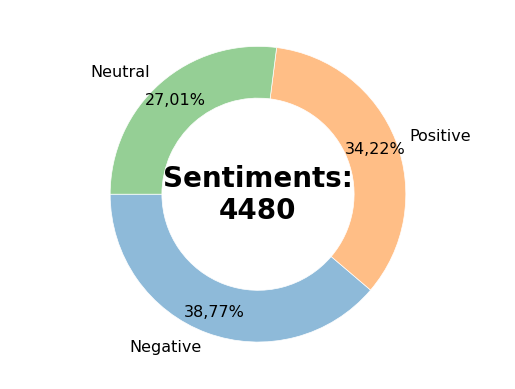

In [35]:
def make_pie(sizes, text, labels, palette, alpha):
    fig, ax = plt.subplots()
    ax.axis('equal')

    colors_with_alpha = [(*color, alpha) for color in palette]

    def my_autopct(pct):
        return '{:.2f}%'.format(pct).replace('.', ',')

    kwargs = dict(colors=colors_with_alpha, startangle=180, autopct=my_autopct,  textprops={'color': 'black', 'fontsize': 11.5})
    outside, _, _ = ax.pie(sizes, radius=1, pctdistance=0.85,
                           labels=labels, **kwargs)

    width = 0.35
    plt.setp(outside, width=width, edgecolor='white')

    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)
    plt.show()

sizes = sentmnt.values
labels = sentmnt.index.get_level_values('label').unique().tolist()
text = "Sentiments:\n{}".format(len(filtered_data))
palette = sns.color_palette("tab10", len(labels))
alpha = 0.5

make_pie(sizes, text, labels, palette, alpha)

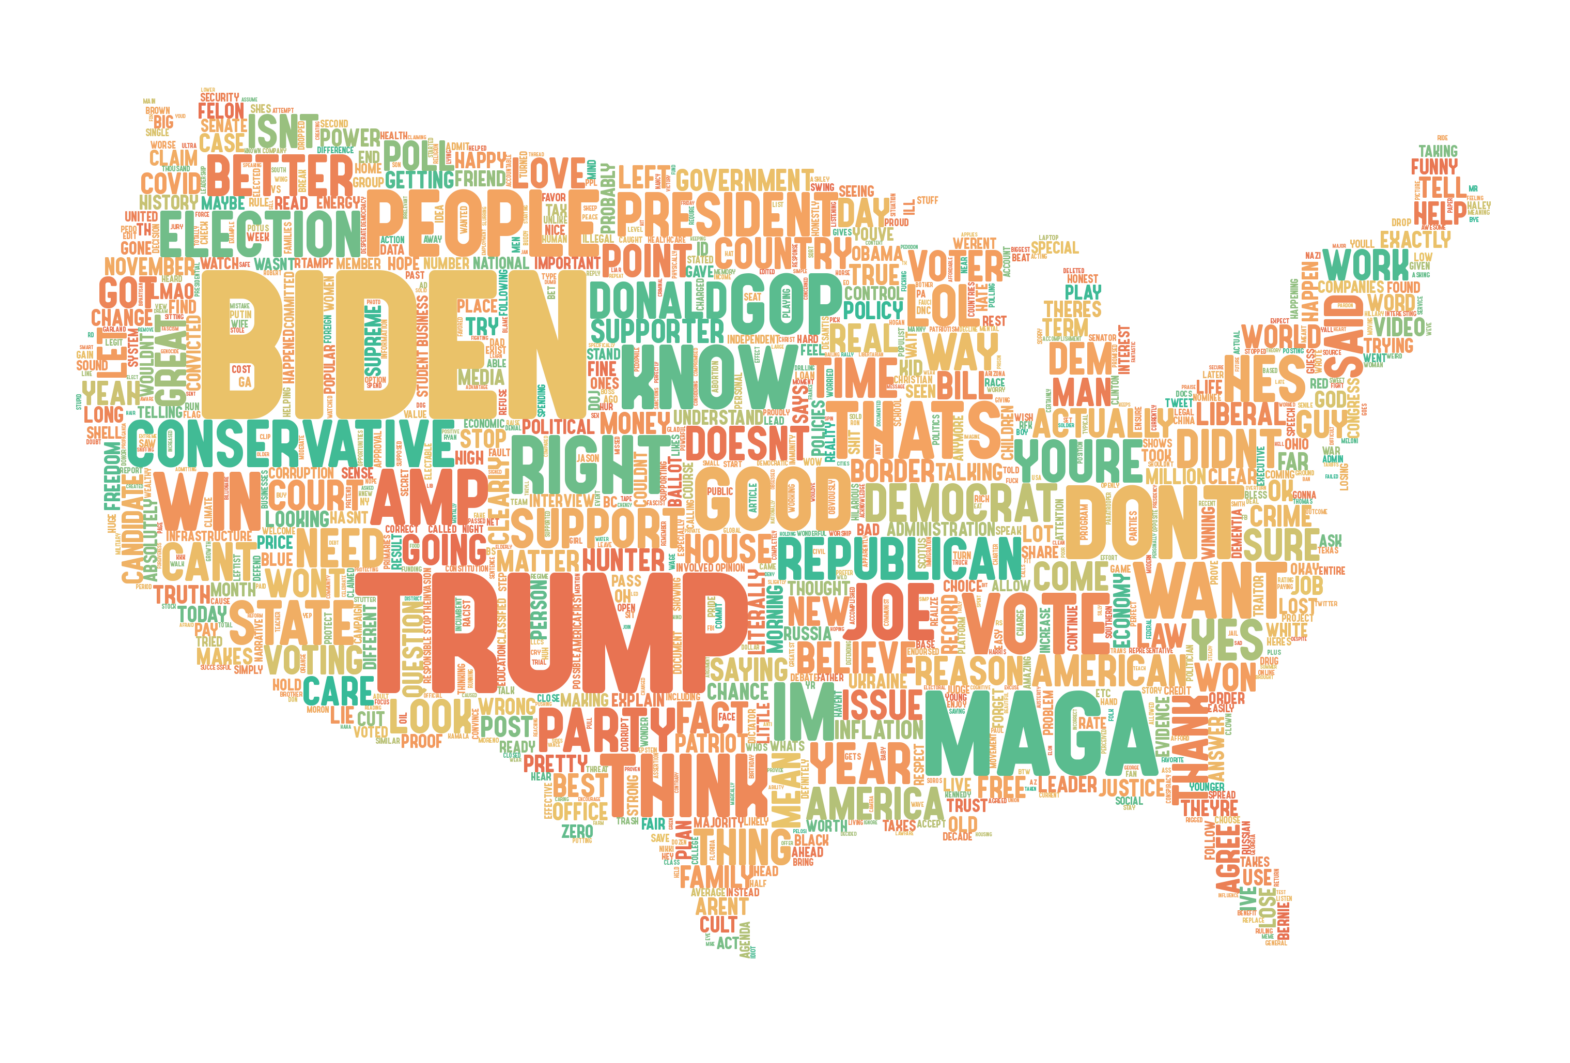

In [39]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

text = " ".join(item for item in filtered_data["processed_text"])

temp_POS = filtered_data[filtered_data["label"] == "Positive"]["processed_text"]
text_POS = " ".join(item for item in temp_POS)
temp_NEG = filtered_data[filtered_data["label"] == "Negative"]["processed_text"]
text_NEG = " ".join(item for item in temp_POS)
temp_NEU = filtered_data[filtered_data["label"] == "Neutral"]["processed_text"]
text_NEU = " ".join(item for item in temp_POS)

nlp = spacy.load("en_core_web_sm")
mask = np.array(Image.open('page_mask.jpg'))
colors = ["#BF0A30", "#002868"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

def generate_wordcloud(data, color_map, label: str):
    wordcloud = WordCloud(background_color="white",
                          font_path = 'Ignazio.ttf', #'Assets/Font/Ignazio.ttf'
                          mask=mask,
                          stopwords=STOPWORDS.union(nlp.Defaults.stop_words),
                          max_words=1000,
                          max_font_size=400,
                          colormap=color_map,
                          collocations=False,
                          width=mask.shape[1],
                          height=mask.shape[0])

    wordcloud.generate(data)

    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.savefig("cloud-"+label+'.png', format="png")
    plt.show()

cmap_pos = LinearSegmentedColormap.from_list("mycmap_pos", ['#36BA98','#E9C46A','#F4A261','#E76F51'])
cmap_neu = LinearSegmentedColormap.from_list("mycmap_neu", ["#22223b","#4a4e69","#9a8c98","#c9ada7"]) #f2e9e4
cmap_neg = LinearSegmentedColormap.from_list("mycmap_neg", ['#bf8799','#382b3d','#20335f','#558ec7'])

#generate_wordcloud(text,cmap,'all')
generate_wordcloud(text_POS,cmap_pos,'pos')
#generate_wordcloud(text_NEU, cmap_neu,'neu')
#generate_wordcloud(text_NEG,cmap_neg,'neg')


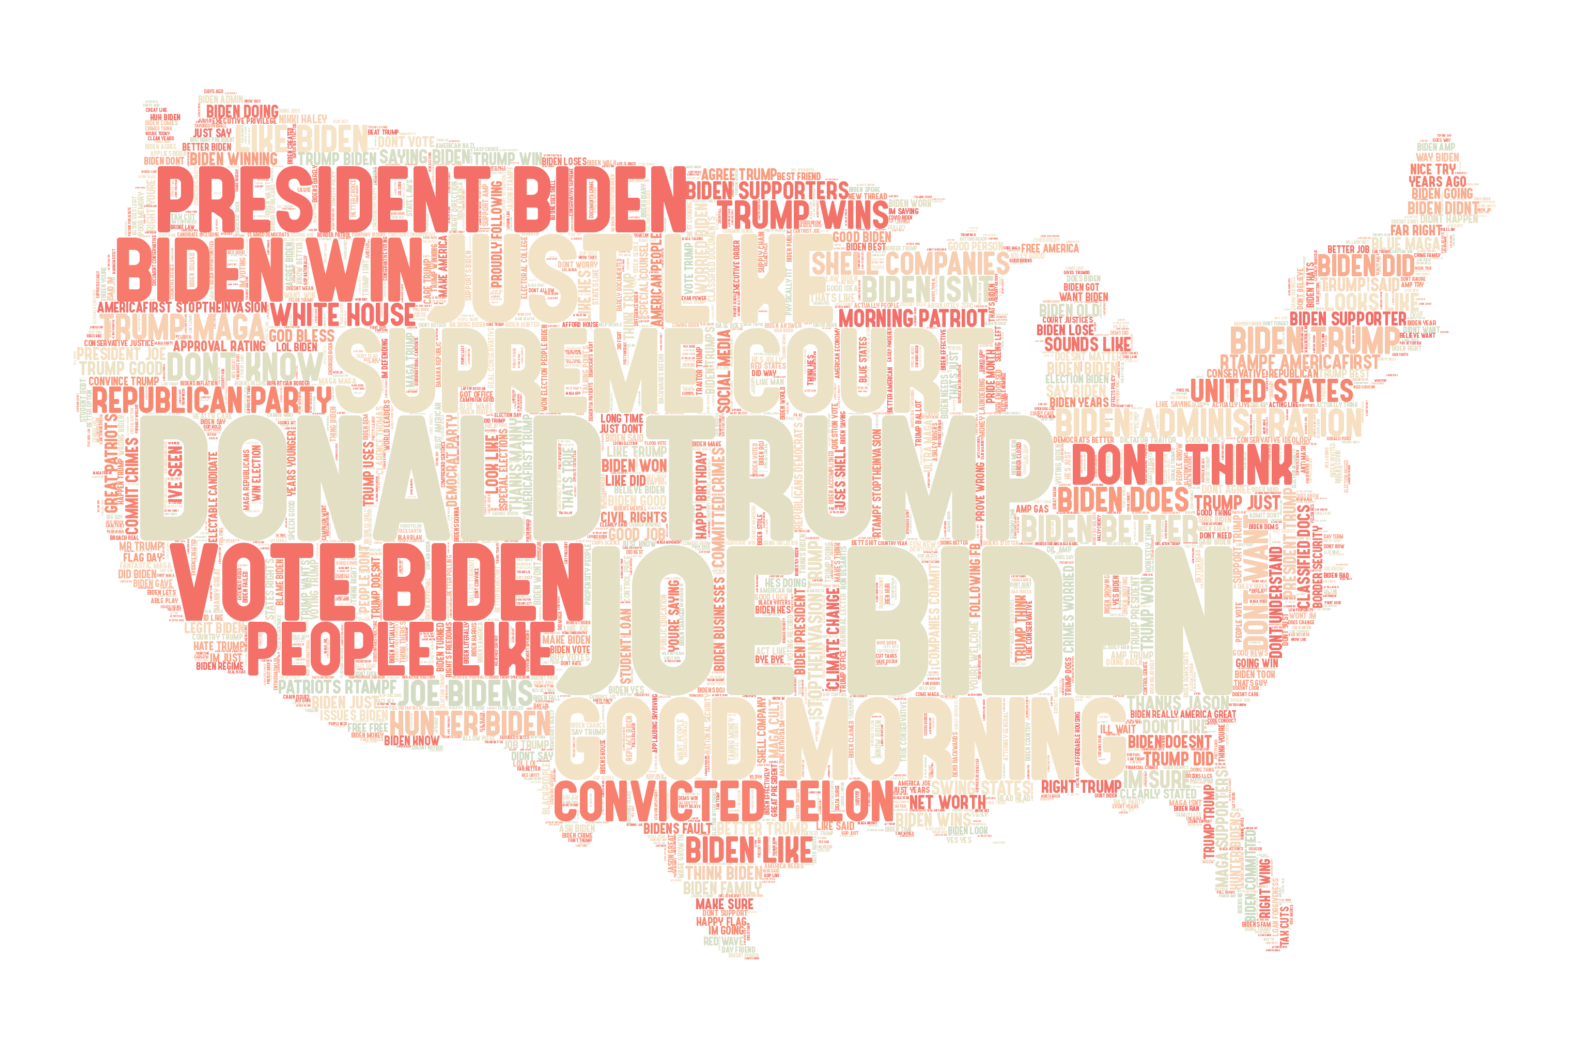

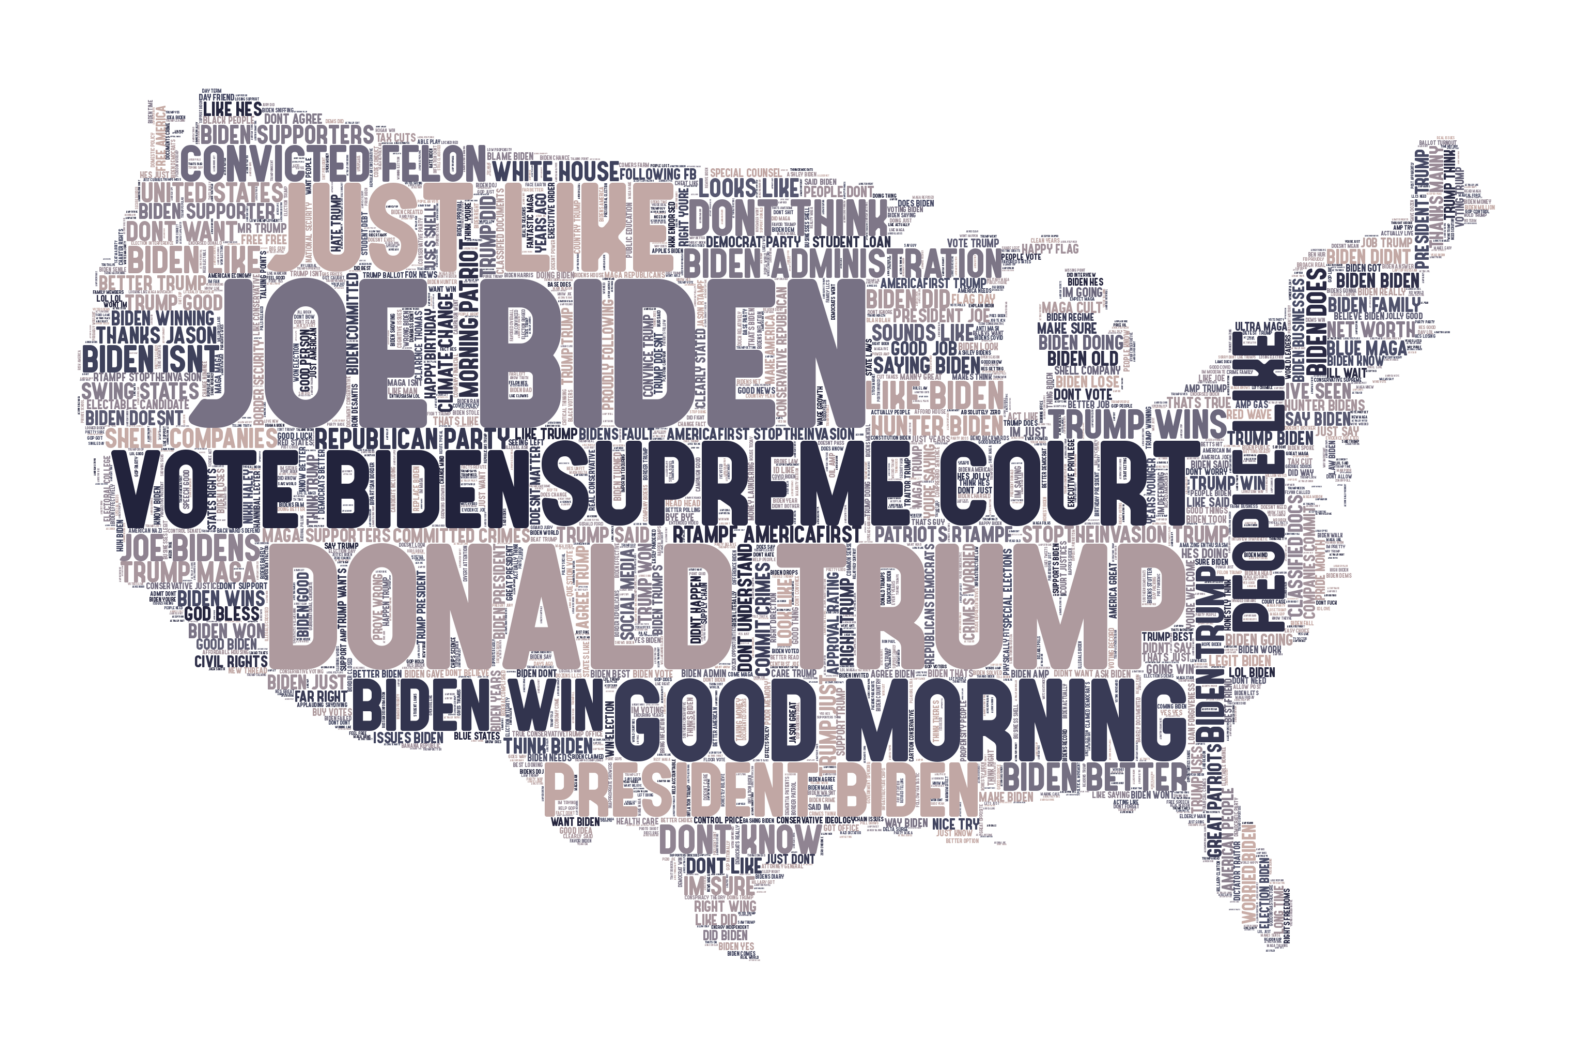

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


def generate_bigram_wordcloud(data, color_map, label:str):
    # Calculating bigrams frequencies using CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    bag_of_words = vectorizer.fit_transform([data])
    bigram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bag_of_words.toarray().sum(axis=0))))

    wordcloud = WordCloud(
        background_color="white",
        font_path='Ignazio.ttf',
        stopwords=STOPWORDS.union(nlp.Defaults.stop_words),
        mask=mask,
        max_words=2000,
        max_font_size=400,
        colormap=color_map,
        width=mask.shape[1],
        height=mask.shape[0],
    ).generate_from_frequencies(bigram_counts)

    plt.figure(figsize=(20, 20))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(f"bigram_cloud_{label}.png", format="png")
    plt.show()

#generate_bigram_wordcloud(text, cmap, 'all')
generate_bigram_wordcloud(text_POS, cmap_pos, 'pos')
generate_bigram_wordcloud(text_NEU, cmap_neu, 'neu')
#generate_bigram_wordcloud(text_NEG, cmap_neg, 'neg')


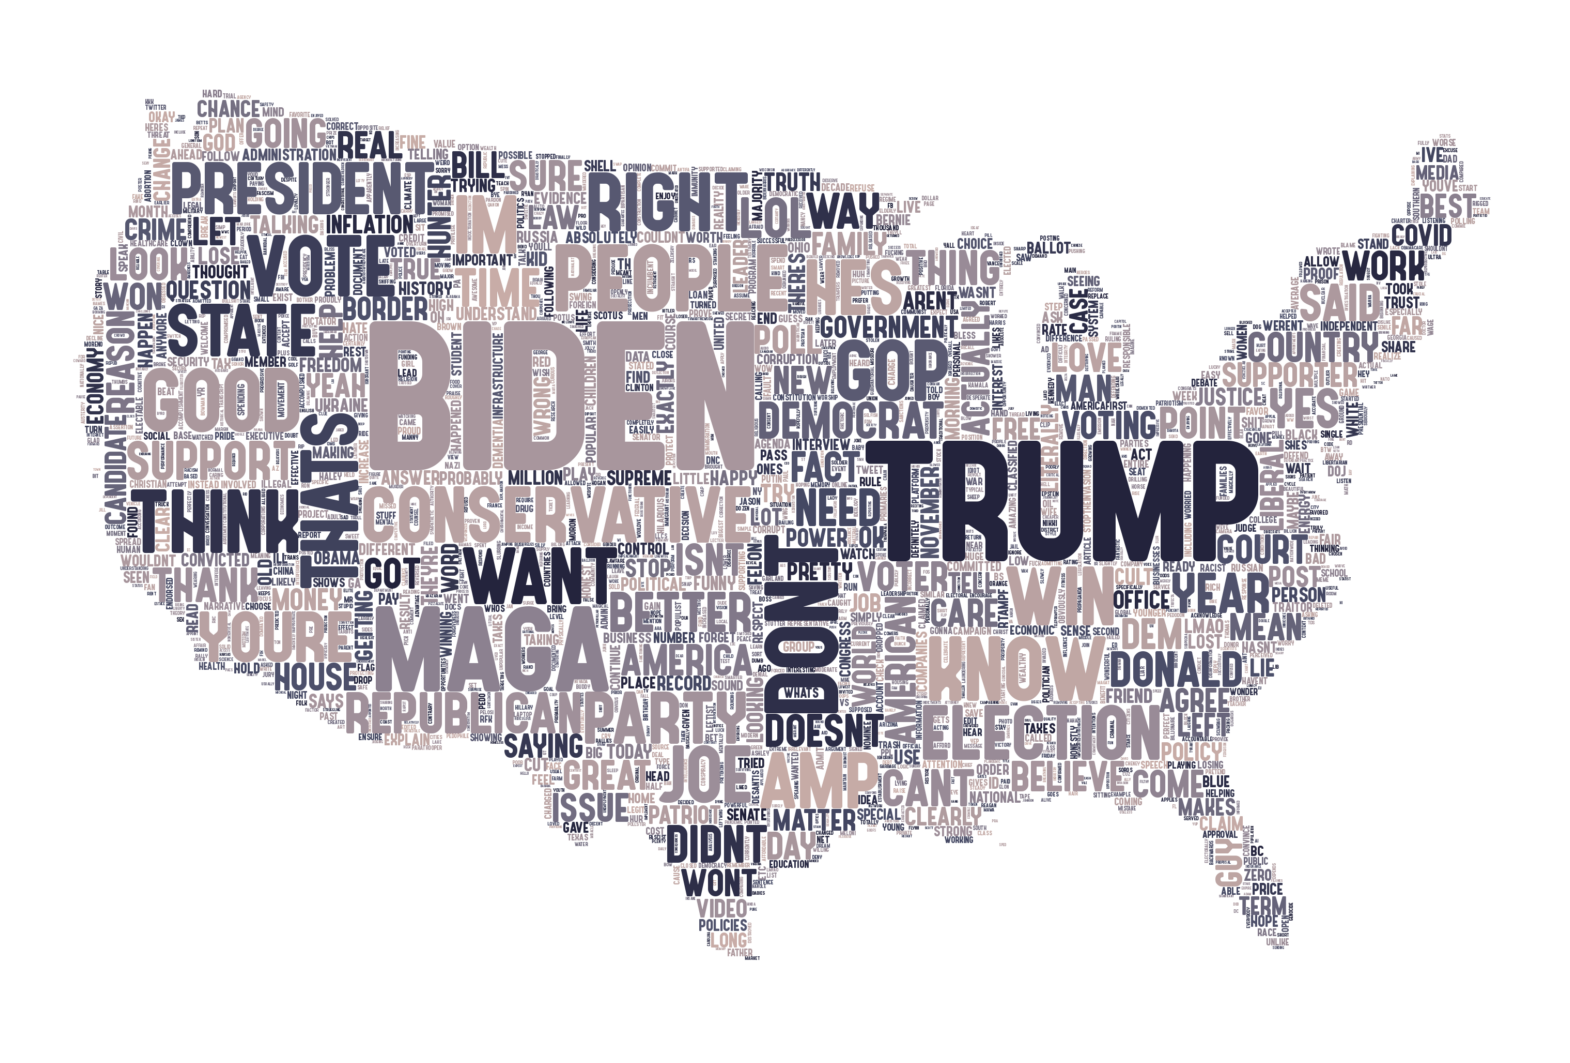

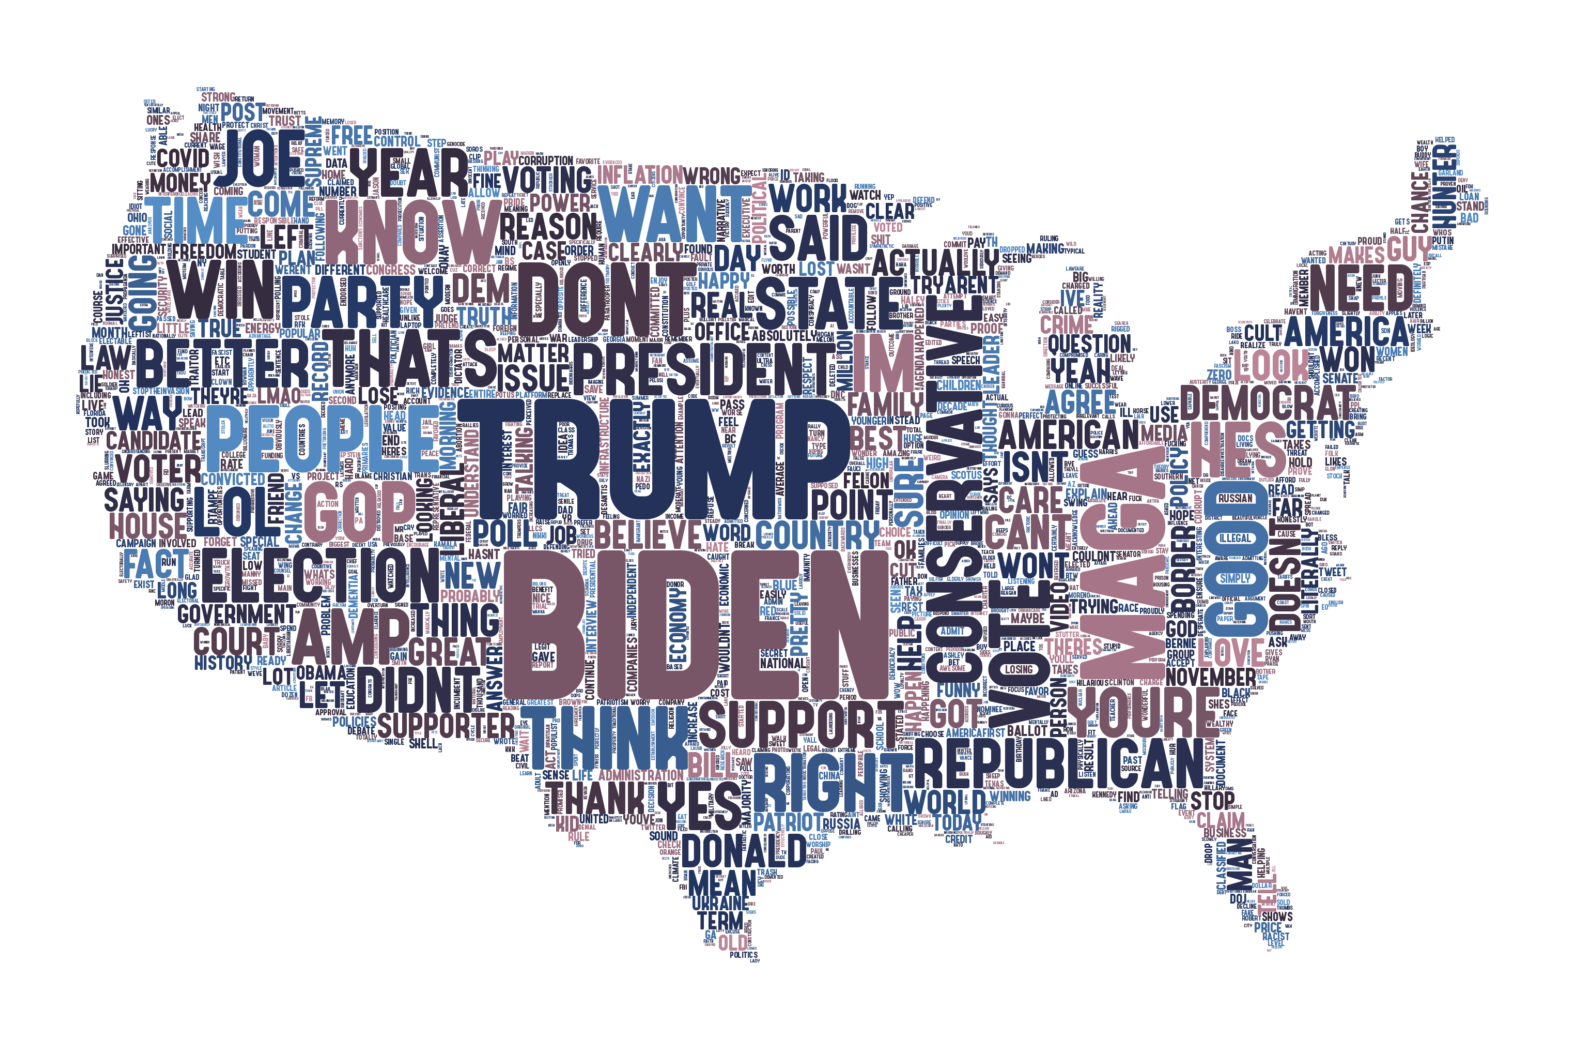

In [ ]:
generate_wordcloud(text_NEU, cmap_neu,'neu')
generate_wordcloud(text_NEG,cmap_neg,'neg')

In [ ]:
# specificare manualmente i bins meglio
filtered_data[(filtered_data['likeCount'] < 100) & (filtered_data['label'] == 'Positive')]['likeCount'].value_counts(bins=10)

(-0.098, 9.7]    1444
(9.7, 19.4]        29
(19.4, 29.1]       15
(29.1, 38.8]       10
(38.8, 48.5]        5
(87.3, 97.0]        5
(48.5, 58.2]        3
(67.9, 77.6]        3
(58.2, 67.9]        2
(77.6, 87.3]        1
Name: count, dtype: int64

In [ ]:
filtered_data[(filtered_data['likeCount'] < 100) & (filtered_data['label'] == 'Negative')]['likeCount'].value_counts(bins=10)

In [ ]:
filtered_data[(filtered_data['likeCount'] < 100) & (filtered_data['label'] == 'Neutral')]['likeCount'].value_counts(bins=10)

In [ ]:
temp = filtered_data[filtered_data['label'] == 'Neutral']
engagementNeu = temp['likeCount'] / temp['followersCount']
engagementNeu.value_counts(bins=10)

##9.9 IDEAS

In [ ]:
# search custom gpts to choose palettes
#likes by sentiment plot,,,,
#engagement by sentiment (likes / followers maybe?) ,,,,,
#minimum separation between nodes
#plot frequencies of words relative to stronger sentiments and compare with frequencies of hashtags ----2----
#compare sentiments with election resulsts -> color map and show percent. and next to image of trump vs harris
#plot sentiment may july vs august ----2-----
#graph statistics of centrality. identifying the most central nodes. Identifying cluster centres. Matching politcs lists?
#identifying the most extremist (surrounded by blue or red only) vs the most neutral figure
# created date (today - created date) vs sentiment (log scale or 1 years vs more) ----1----
# distribution of difference followers vs following ---1--- scatterplot + finding  a treshold for bots and public figures + category matrix
# add plot to test hypothesis
# hierarchical clustering with compound scores
# correlation clustering pos neg
# k-means
# top 5 hashtags per each state and per usa total ---------1